 # Simple summary statistics

 ##

In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from mpl_toolkits.axes_grid1 import make_axes_locatable

from src.data import load_metagraph
from src.graph import MetaGraph, preprocess
from src.hierarchy import signal_flow
from src.io import readcsv, savecsv, savefig
from src.visualization import (
    CLASS_COLOR_DICT,
    adjplot,
    barplot_text,
    get_mid_map,
    gridmap,
    matrixplot,
    remove_axis,
    remove_shared_ax,
    remove_spines,
    set_axes_equal,
    set_style,
    stacked_barplot,
)
from scipy.stats import pearsonr, spearmanr
from pkg.data import load_data
from pkg.plot import set_theme

set_theme()


In [2]:
data = load_data("G")
adj = data.adj
meta = data.meta
g = data.graph
print(len(g))

3079


In [3]:

n_nodes = len(meta)
n_edges = (adj != 0).sum()
n_synapse_pairs = int(adj.sum())
print(f"Number of nodes: {n_nodes}")
print(f"Number of edges: {n_edges}")
print(f"Number of synaptic pairings: {n_synapse_pairs}")


Number of nodes: 3079
Number of edges: 106551
Number of synaptic pairings: 338131


In [4]:
nbunch = meta.index.values
meta["out_degree_unweighted"] = meta.index.map(dict(g.out_degree(nbunch, weight=None)))
meta["in_degree_unweighted"] = meta.index.map(dict(g.in_degree(nbunch, weight=None)))
meta["out_degree_weighted"] = meta.index.map(
    dict(g.out_degree(nbunch, weight="weight"))
)
meta["in_degree_weighted"] = meta.index.map(dict(g.in_degree(nbunch, weight="weight")))

degrees = meta[
    [
        "out_degree_unweighted",
        "in_degree_unweighted",
        "out_degree_weighted",
        "in_degree_weighted",
    ]
]


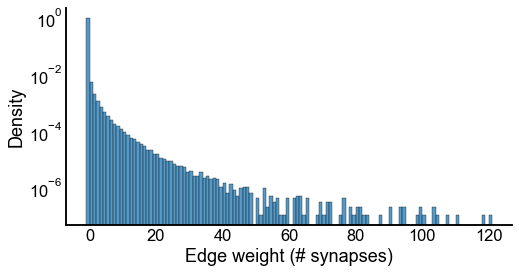

In [5]:
inds = np.nonzero(adj)
weights = adj.ravel().copy()  # [inds]
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
bins = np.linspace(-1, weights.max(), int(weights.max() + 2)) + 0.01
sns.histplot(weights, ax=ax, log_scale=False, kde=False, bins=bins, stat="density")
ax.set_ylabel("Density")
ax.set_xlabel("Edge weight (# synapses)")
ax.set_yscale("log")



 ##

<ipython-input-6-6df5acaac1e9>:40: MatplotlibDeprecationWarning:

In a future version, 'pad' will default to rcParams['figure.subplot.hspace'].  Set pad=0 to keep the old behavior.

<ipython-input-6-6df5acaac1e9>:45: MatplotlibDeprecationWarning:

In a future version, 'pad' will default to rcParams['figure.subplot.wspace'].  Set pad=0 to keep the old behavior.



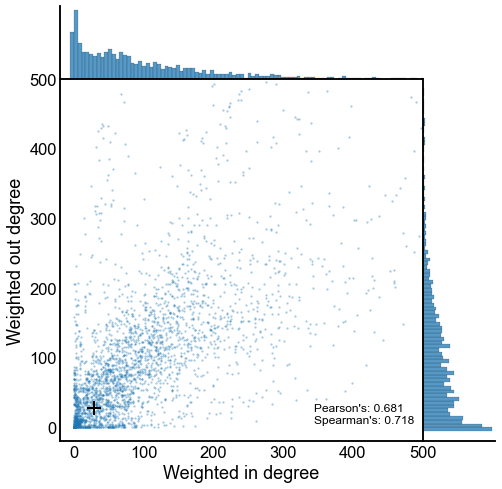

In [6]:
log_scale = False
distplot_kws = dict(kde=False)
ylabel = "Weighted out degree"
xlabel = "Weighted in degree"
fig, ax = plt.subplots(1, 1, figsize=(8, 8))

median_degrees = np.median(degrees, axis=0)
median_in_degree = median_degrees[0]
median_out_degree = median_degrees[1]

n_bins_log = 50
n_bins_linear = 300
if log_scale:
    degrees[degrees == 0] += 0.5
    ax.set_yscale("log")
    ax.set_xscale("log")
    bins = np.geomspace(degrees.min().min(), degrees.max().max(), n_bins_log)
else:
    start = -1 / (n_bins_linear - 1) * degrees.max().max()
    bins = np.linspace(start, degrees.max().max(), n_bins_linear)

sns.scatterplot(
    data=degrees,
    x="in_degree_weighted",
    y="out_degree_weighted",
    s=5,
    alpha=0.4,
    linewidth=0,
    ax=ax,
)
ax.scatter(
    median_in_degree, median_out_degree, s=200, marker="+", color="black", linewidth=2
)

ax.set_ylabel(ylabel)
ax.set_xlabel(xlabel)


divider = make_axes_locatable(ax)
top_ax = divider.append_axes("top", size="20%", sharex=ax)
sns.histplot(x=degrees["in_degree_weighted"], ax=top_ax, bins=bins, **distplot_kws)
top_ax.xaxis.set_visible(False)
top_ax.yaxis.set_visible(False)

right_ax = divider.append_axes("right", size="20%", sharey=ax)
sns.histplot(
    y=degrees["out_degree_weighted"],
    ax=right_ax,
    bins=bins,
    **distplot_kws,
)
right_ax.yaxis.set_visible(False)
right_ax.xaxis.set_visible(False)
ax.axis("square")


pearsons, _ = pearsonr(degrees["in_degree_weighted"], degrees["out_degree_weighted"])
spearmans, _ = spearmanr(degrees["in_degree_weighted"], degrees["out_degree_weighted"])
ax.text(
    0.7,
    0.05,
    f"Pearson's: {pearsons:0.3f}\nSpearman's: {spearmans:0.3f}",
    transform=ax.transAxes,
    fontsize=12,
)

if not log_scale:
    ax.set_xlim((-20, 500))
    ax.set_ylim((-20, 500))
